# Classifying Fashion-MNIST

In [1]:
import torch
from torchvision import datasets, transforms
import helper

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

26422272it [01:29, 295265.41it/s]                              


Extracting C:\Users\Roy/.pytorch/F_MNIST_data/FashionMNIST\raw\train-images-idx3-ubyte.gz to C:\Users\Roy/.pytorch/F_MNIST_data/FashionMNIST\raw



29696it [00:00, 155538.78it/s]                          


Extracting C:\Users\Roy/.pytorch/F_MNIST_data/FashionMNIST\raw\train-labels-idx1-ubyte.gz to C:\Users\Roy/.pytorch/F_MNIST_data/FashionMNIST\raw



4422656it [00:13, 331504.14it/s]                             


Extracting C:\Users\Roy/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to C:\Users\Roy/.pytorch/F_MNIST_data/FashionMNIST\raw



6144it [00:00, ?it/s]                   
C:\Users\Roy\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting C:\Users\Roy/.pytorch/F_MNIST_data/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to C:\Users\Roy/.pytorch/F_MNIST_data/FashionMNIST\raw

Processing...
Done!


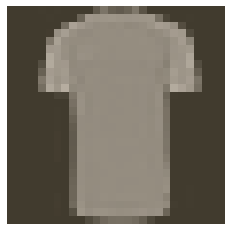

In [2]:
image, label = next(iter(trainloader))
helper.imshow(image[0,:]);

## Building the network

In [3]:
from torch import nn, optim
import torch.nn.functional as F

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

## Train the Network

In [5]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [7]:
torch.cuda.is_available()

True

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
epochs = 10

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print(f"Training loss: {running_loss/len(trainloader)}")

Training loss: 0.5786353946049839
Training loss: 0.46357608846287485
Training loss: 0.43611419674302976
Training loss: 0.4254330994605001
Training loss: 0.4231910589915603
Training loss: 0.39987043388235544
Training loss: 0.3922278689010057
Training loss: 0.3816085063191111
Training loss: 0.3754915902450649
Training loss: 0.37042892278670503


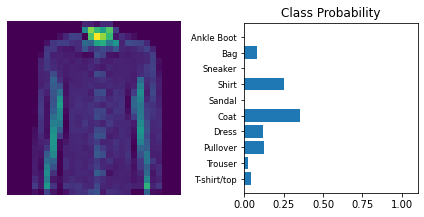

In [11]:
import helper

# Test out your network!

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[1]

ps = torch.exp(model(img))

# Plot the image and probabilities
helper.view_classify(img, ps, version='Fashion')

# Saving and Load Models

In [16]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [17]:
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias', 'fc4.weight', 'fc4.bias'])


In [18]:
model.load_state_dict(state_dict)

<All keys matched successfully>

In [19]:
model

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

# Inference and Validation

In [20]:
images, labels = next(iter(testloader))
# Get the class probabilities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

torch.Size([64, 10])


In [21]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for the first 10 examples
print(top_class[:10,:])

tensor([[8],
        [3],
        [0],
        [1],
        [1],
        [8],
        [1],
        [5],
        [6],
        [0]])


In [22]:
model = Classifier()
criterion = nn.NLLLoss(reduction='sum')
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30

train_losses, test_losses = [], []
for e in range(epochs):
    tot_train_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        tot_train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
    else:
        tot_test_loss = 0
        test_correct = 0  # Number of correct predictions on the test set
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                tot_test_loss += loss.item()

                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                test_correct += equals.sum().item()

        # Get mean loss to enable comparison between train and test sets
        train_loss = tot_train_loss / len(trainloader.dataset)
        test_loss = tot_test_loss / len(testloader.dataset)

        # At completion of epoch
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss),
              "Test Loss: {:.3f}.. ".format(test_loss),
              "Test Accuracy: {:.3f}".format(test_correct / len(testloader.dataset)))

Epoch: 1/30..  Training Loss: 0.511..  Test Loss: 0.434..  Test Accuracy: 0.839
Epoch: 2/30..  Training Loss: 0.388..  Test Loss: 0.401..  Test Accuracy: 0.851
Epoch: 3/30..  Training Loss: 0.352..  Test Loss: 0.402..  Test Accuracy: 0.851
Epoch: 4/30..  Training Loss: 0.332..  Test Loss: 0.372..  Test Accuracy: 0.868
Epoch: 5/30..  Training Loss: 0.315..  Test Loss: 0.388..  Test Accuracy: 0.864
Epoch: 6/30..  Training Loss: 0.298..  Test Loss: 0.391..  Test Accuracy: 0.867
Epoch: 7/30..  Training Loss: 0.289..  Test Loss: 0.349..  Test Accuracy: 0.874
Epoch: 8/30..  Training Loss: 0.281..  Test Loss: 0.383..  Test Accuracy: 0.866
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.374..  Test Accuracy: 0.872
Epoch: 10/30..  Training Loss: 0.262..  Test Loss: 0.377..  Test Accuracy: 0.869
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.369..  Test Accuracy: 0.874
Epoch: 12/30..  Training Loss: 0.251..  Test Loss: 0.374..  Test Accuracy: 0.876
Epoch: 13/30..  Training Loss: 0.246.

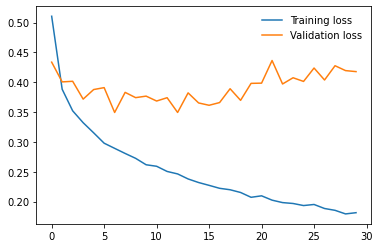

In [23]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)